In [1]:
from numpy import array
import time
import os
from itertools import product
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
import pickle

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier

from sklearn.inspection import permutation_importance
#Model Performance Evaluators
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

from sklearn.utils.class_weight import compute_class_weight


import joblib
from joblib import parallel_backend
from joblib import Parallel, delayed
import dask
from dask.distributed import Client, progress, LocalCluster, SSHCluster,wait


import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

from sklearn.inspection import PartialDependenceDisplay
from sklearn.inspection import partial_dependence
from PyALE import ale

from dask import delayed

In [2]:
comb_dinuc_df= pd.read_csv('/cluster/pixstor/slotkinr-lab/sandaruwan/frNAnet/train/multi_sample/S17212204_dinuc_pct_df.txt',header=0,sep='\t')


np.shape(comb_dinuc_df)

#Shuffle and reset index
shuf_comb_dinuc_df=comb_dinuc_df.iloc[np.random.permutation(len(comb_dinuc_df))]

shuf_comb_dinuc_df=shuf_comb_dinuc_df.reset_index(drop=True)



In [3]:

ydt=shuf_comb_dinuc_df['ptype']
xdt=shuf_comb_dinuc_df.drop(['seq_id','ptype'],axis=1)

In [4]:
######################### split data #####################################

#split test train data
Xdt_train, Xdt_test, ydt_train, ydt_test = train_test_split(xdt, ydt, test_size=0.2, random_state=256)

Xdt_train.shape, Xdt_test.shape

((968026, 23), (242007, 23))

In [5]:
with parallel_backend('threading',n_jobs=64 ):

     # Calculate class weights
    class_weights = compute_class_weight('balanced', classes=np.unique(ydt_train), y=ydt_train)
    class_weights

    #rfc_dicomb = RandomForestClassifier(random_state=3500,n_estimators = 200,class_weight=dict(enumerate(class_weights) ))


    #'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 100, 'criterion': 'log_loss', 'bootstrap': True

    rfc_dicomb= RandomForestClassifier(n_estimators=250,
       criterion='entropy',
       max_depth=None,
       min_samples_split=2,
       min_samples_leaf=1,
       max_features='sqrt',
       bootstrap=False,
       n_jobs=64,
       random_state=2048,
       class_weight=dict(enumerate(class_weights))
    )

    #Best Parameters:  {'bootstrap': False, 'criterion': 'entropy', 'max_depth': None, 
                   #'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 250}


    print('training >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
    
    rfc_dicomb.fit(Xdt_train, ydt_train)


    # Predict the Test set results

    y_pred =  rfc_dicomb.predict(Xdt_test)

    

training >>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>


In [6]:
# test accuracy score 

from sklearn.metrics import accuracy_score

print('Model test accuracy : {0:0.4f}'. format(accuracy_score(ydt_test, y_pred)))



print ("\nClassification report :\n",(classification_report(ydt_test,y_pred)))

Model test accuracy : 0.8922

Classification report :
               precision    recall  f1-score   support

           0       0.89      0.92      0.90    133814
           1       0.90      0.85      0.88    108193

    accuracy                           0.89    242007
   macro avg       0.89      0.89      0.89    242007
weighted avg       0.89      0.89      0.89    242007



In [7]:
mfilename='/cluster/pixstor/slotkinr-lab/sandaruwan/rubyRF/RED_FG/RED_FG_models/rfc_RED_FG_comb_tr4_v1.pkl'

pickle.dump( rfc_dicomb,open(mfilename,'wb'))

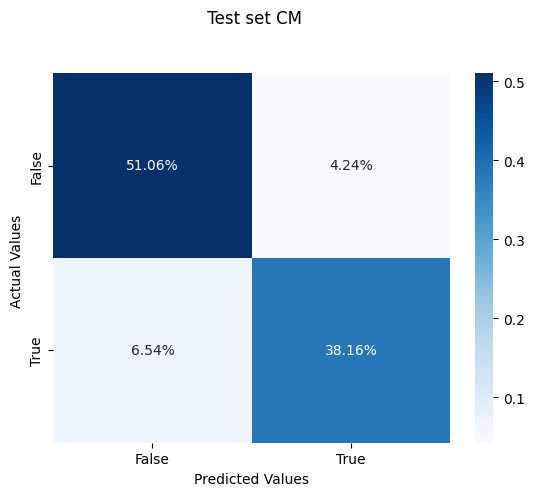

In [8]:
fig1=plt.figure()
cm = confusion_matrix(y_true=ydt_test, y_pred=y_pred)

ax = sns.heatmap(cm/np.sum(cm), annot=True,
            fmt='.2%', cmap='Blues')

ax.set_title(' Test set CM\n\n');
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])


fig1 = ax.get_figure()

fig1.savefig("RFC_comb_SRJS_v2.pdf")

In [9]:
client = Client(processes=False, threads_per_worker=1, n_workers=64, memory_limit='256GB')

2024-09-03 17:37:51,413 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-09-03 17:38:13,609 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-09-03 17:38:17,849 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-09-03 17:38:22,358 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-09-03 17:38:26,644 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-09-03 17:38:31,268 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-09-03 17:38:35,665 - distributed.utils_perf - WARNING - full garbage collections took 10% CPU time recently (threshold: 10%)
2024-09-03 17:38:40,296 - distributed.utils_perf - WARNING - full garbage collections took

In [10]:
start_time=time.time()


# Scatter X data to workers
Xdt_test_dask = client.scatter(Xdt_test, broadcast=True)
# Scatter y data to workers
ydt_test_dask = client.scatter(ydt_test, broadcast=True)  


@dask.delayed
def compute_permutation_importance(model, X, y, n_repeats=10, random_state=42):
    
    result = permutation_importance(model, X, y, n_repeats=n_repeats, random_state=random_state)
    return result

# Compute permutation importance with Dask delayed computation
perm_importance_delayed = compute_permutation_importance(rfc_dicomb, Xdt_test_dask, ydt_test_dask)

# Compute the result
perm_importance_t3 = perm_importance_delayed.compute()


end_time=time.time()
total_time=end_time-start_time
print("execution time",total_time,"s")

/mnt/pixstor/data/tsrbcx/miniconda/envs/sickt_ml/lib/python3.10/site-packages/distributed/client.py:3164: UserWarning: Sending large graph of size 5.83 GiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


execution time 210.5535717010498 s


In [11]:
client.close()

In [19]:
sorted_idx = perm_importance_t3.importances_mean.argsort()
top_fidx=sorted_idx[-21:]

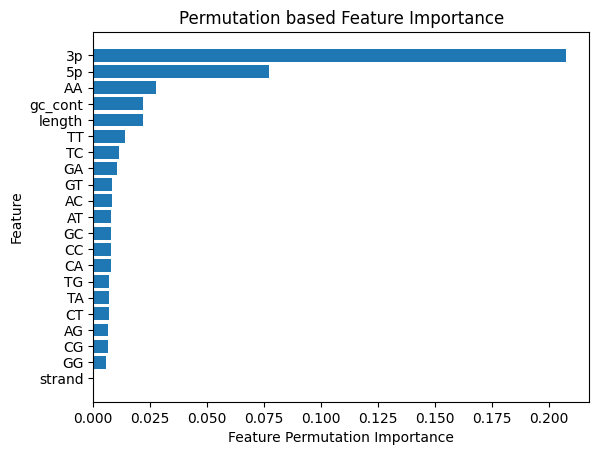

In [20]:
plt.rcParams.update({'font.size': 10})
fig4=plt.figure()
plt.barh(Xdt_train.columns[top_fidx], perm_importance_t3.importances_mean[top_fidx])
plt.xlabel("Feature Permutation Importance")
plt.ylabel('Feature')
plt.title('Permutation based Feature Importance')
fig4.savefig("RFC_comb_RED_FG_prem_importance.pdf")

In [16]:
difetures=['3p','5p','AA','length']

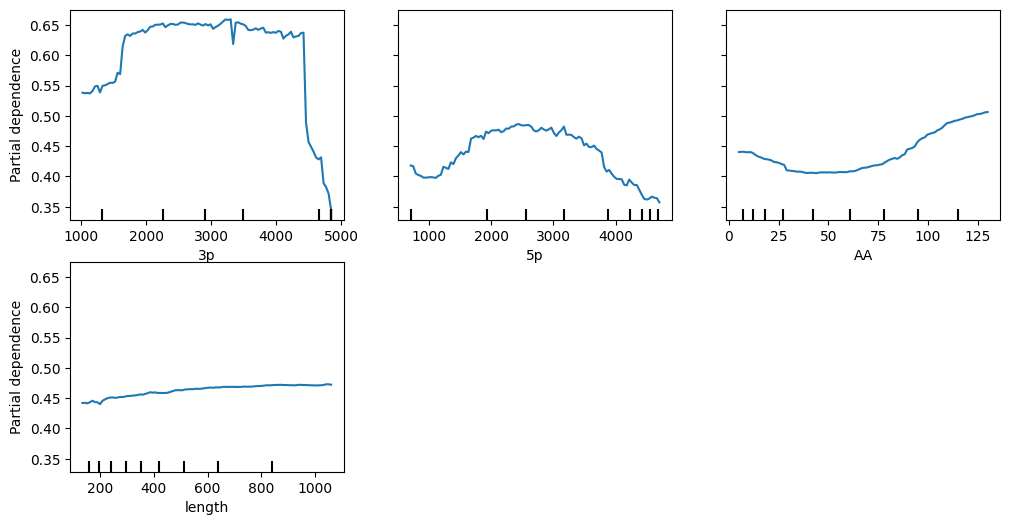

In [17]:

fig2, ax = plt.subplots(figsize=(12, 6))

tree_disp = PartialDependenceDisplay.from_estimator(rfc_dicomb,X=Xdt_test,features=difetures, ax=ax,n_jobs=64)


In [18]:
fig2.savefig('RED_FG_tr4_v1pdp.pdf',dpi=300)